In [16]:
__author__ = 'dareia'

In [17]:
import os
import pandas as pd
import numpy as np
from pandas import read_excel
import re
import pprint
pp = pprint.PrettyPrinter()
directory = os.path.join("/Users", "dareia", "latsem", "Annotated data")
import matplotlib.pyplot as plt
import ast
import itertools

In [18]:
import textwrap
import matplotlib.pyplot as plt  
import seaborn as seabornInstance;  seabornInstance.set()
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [19]:
plt.rcParams['figure.figsize'] = [7, 20]

In [20]:
def printsep(s):
    print(s*30)

#### copied from Barbara's code and adapted:

In [21]:
def normalize_ratings(ratings):
    printsep('+')
    print("Normalizing ratings...")
    print("shape:", str(ratings.shape))
    ratings = ratings.dropna()
    for i in ratings.index:
        for y in range(ratings.shape[1]):
            if len(str(ratings.iat[i, y])) > 3:
                ratings.iat[i, y] = int(ratings.iat[i, y].split(': ')[0])
    print(str(ratings))
    print("... ratings normalized")
    printsep('+')
    return ratings

In [22]:
def annotator_probability(maxmeanings, probs):
    ratings = [0, 1, 2, 3, 4]
    combinations = []
    pattern_probability = {}
    for i in range(2,maxmeanings+1):
        combinations.extend([list(p) for p in itertools.combinations_with_replacement(ratings, i)])
    for pattern in combinations:
        probability = 1
        for elem in pattern:
            try:
                probability *= probs[elem]
            except KeyError:            # this handles the cases where an annotator never used a rating
                probability *= 0
        pattern_probability[str(pattern)] = probability
    return pattern_probability

# Reading data from spreadsheets (.xslx)

In [23]:
paths = [f for f in os.listdir(directory)][1:]
print(paths)

['annotation_task_acerbus_ANNIE_metadata.xlsx', 'annotation_task_adsumo_DARIA_metadata.xlsx', 'annotation_task_ancilla_ANNIE_metadata.xlsx', 'annotation_task_beatus_HUGO_metadata.xlsx', 'annotation_task_civitas_HUGO_metadata.xlsx', 'annotation_task_cohors_ROZI_metadata.xlsx', 'annotation_task_consilium_ANNIE_metadata.xlsx', 'annotation_task_consul_HUGO_metadata.xlsx', 'annotation_task_credo_PAOLA_metadata.xlsx', 'annotation_task_dolus_DARIA_metadata.xlsx', 'annotation_task_dubius_HELENA_metadata.xlsx', 'annotation_task_dux_HUGO_metadata.xlsx', 'annotation_task_fidelis_HUGO_metadata.xlsx', 'annotation_task_honor_DARIA_metadata.xlsx', 'annotation_task_hostis_ANNIE_metadata.xlsx', 'annotation_task_humanitas_DARIA_metadata.xlsx', 'annotation_task_imperator_HUGO_metadata.xlsx', 'annotation_task_itero_HUGO_metadata.xlsx', 'annotation_task_jus_ROZI_metadata.xlsx', 'annotation_task_licet_TOMAZ_metadata.xlsx', 'annotation_task_necessarius_HUGO_metadata.xlsx', 'annotation_task_nepos_DARIA_metada

In [24]:
spreadsheets = []

#### HERE GOES THE LOOP

In [ ]:
for path in paths:
    printsep('-|-|')
    print('Working with the file ' + path)
    s = {} # will write all information from the spreadsheet to this dict
    split = re.split('_', path)
    s['annotator'] = split[3]
    s['word'] = split[2]
    # OPEN FILE
    df = read_excel(os.path.join(directory, path),
                                  sheet_name=0, encoding='utf-8', dtype=object)
    df.columns = [name.lower() for name in df.columns]
    df.replace('', np.NaN, inplace=True)
    df = df.dropna(how='all')
    print(df.tail())
    #s['file'] = df # not sure i need that
    # GET MEANINGS AND THEIR NUMBER
    column_headings = list(df.columns)
    print(column_headings)
    try:
        x = column_headings.index('right context')+1 #where metadata and test sentence ends
        y = column_headings.index('comments') #the last column (also checks whether it is "comments")
        meanings = [m.replace('\xa0', ' ') for m in column_headings[x:y]] #dealing with the \xa0 character
    except ValueError:
        print("No such columns in the spreadsheet.")
        meanings = []
        break
    print('Extracted meanings are:')
    print(meanings)
    s['meanings'] = meanings
    #add number of meanings to the dictionary
    s['number of meanings'] = len(meanings)
    #print(s['cells'])
    # FIND COMMENTS, COUNT THE NUMBER
    comments = df.dropna()
    print(comments)
    s['comments'] = comments
    s['number of comments'] = comments.shape[0]
    # SELECT A SUBSET WITH ONLY MEANINGS AND RATINGS + INDEX
    df_ratings = df.iloc[:, x:y]
    df_ratings = normalize_ratings(df_ratings)
    s['rows'] = df_ratings.shape[0]
    s['cells'] = s['rows'] * s['number of meanings']
    print(df_ratings.head())
    printsep('-')
    # COUNT UNIQUE PATTERNS OF ANNOTATION
    all_rating_patterns = []
    for i in range(df_ratings.shape[0]):
        pattern = str((sorted(df_ratings.iloc[i].to_list())))
        all_rating_patterns.append(pattern)
    unique_rating_patterns = set(all_rating_patterns)
    rating_patterns_counted = {}
    for p in all_rating_patterns:
        if p in rating_patterns_counted.keys():
            rating_patterns_counted[p] += 1
        else:
            rating_patterns_counted[p] = 1
    #pp.pprint(rating_patterns_counted)
    #print(rating_patterns_counted)
    # turn dictionary into a Series, then DataFrame (there must be a better way, but this works so far...)
    rating_patterns_counted = pd.Series(rating_patterns_counted)
    rating_patterns_counted = pd.DataFrame({'pattern': rating_patterns_counted.index, 'count': rating_patterns_counted.values})      # result
    print("Unique rating patterns:")
    pp.pprint(rating_patterns_counted)
    s['rating patterns'] = rating_patterns_counted
    printsep('-')
    # COUNT ALL VALUES ACCROSS THE DATAFRAME
    # stack all columns, do value_counts()
    arc = df_ratings.stack().value_counts()
    # add absolute numbers and their relative frequency to a dataframe
    arc = pd.DataFrame({'rating':arc.index,
                                        'absolute number':arc.values,
                                        'frequency': arc.values / s['cells']})   # result
    print("All ratings:")
    print(arc)
    try:
        fours = arc.loc[arc['rating'] == 4, 'absolute number'].item()
    except ValueError:
        fours = 0
    try:
        threes = arc.loc[arc['rating'] == 3, 'absolute number'].item()
    except ValueError:
        threes = 0
    try:
        twos = arc.loc[arc['rating'] == 2, 'absolute number'].item()
    except ValueError:
        twos = 0
    conf =  fours / (fours + threes + twos)
    s['individual ratings frequency'] = arc
    s['confidence'] = conf
    # SHOW RESULTING DICTIONARY
    pp.pprint(s)
    # ADD THIS WHOLE THING TO THE LIST OF DATA ON SPREADSHEETS
    spreadsheets.append(s)
    # plot a heatmap of ratings, sorted by date)
    if 'metadata.1' in df.columns: # quick fix; something happened with the metadata files, an extra column at the beginning? TODO ask Barbara!! 
        metadata = df['metadata.1']
    else:
        metadata = df['metadata']
    dates = []
    for line in metadata:
        #print(line)
        try:
            match = re.search(',cent\. (.+?),', line)
            if match:
                datestr = match.group(1)
                century = datestr.split()[0]
                era = datestr.split()[1]
                #print(datestr)
                if '-' in century:
                    date = (int(century.split('-')[0])+int(century.split('-')[1]))/2
                else:
                    date = int(century)
                if datestr.split()[1] == 'B.':
                    date = int(-date)
                #print(date)
                dates.append(date)
            else: 
                print('ERROR! '*3)
                print(line)
                while True:
                    try:
                        date = float(input('Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.'))
                    except ValueError:
                        print("Not a valid number! Try again.")
                        continue
                    else:
                        dates.append(date)
                        break 
        except TypeError:
            continue 
    df_ratings['date: century'] = dates
    df_ratings.fillna(value=np.nan, inplace=True)
    df_ratings_sorted = df_ratings.sort_values(by=['date: century'])
    df_ratings_sorted.index = df_ratings_sorted['date: century']
    plt.clf()
    plt.figure(figsize=(10, 16))
    g = seabornInstance.heatmap(df_ratings_sorted.iloc[:,:-1], 
                            cmap='Blues', 
                            vmin=0, 
                            #xticklabels=meanings_short,
                            annot=True
                           )
    #g.set_xticklabels(g.get_xticklabels(), , wrap=True)
    g.set_xticklabels([textwrap.fill(e.replace('\xa0', ' '), 15, break_long_words=False) for e in df_ratings_sorted.columns], rotation =30)
    plt.title(s['word'])
    plt.savefig(s['word']+".png", bbox_inches='tight')
    plt.clf()

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_acerbus_ANNIE_metadata.xlsx
                                             metadata era  \
55  unknown,de rerum natura,ca. 97-55 B. C.,cent. ...  BC   
56  Plautus,Rudens,ca. 254-184 B. C.,cent. 3-1 B. ...  BC   
57  [Auctor incertus],De bello Africo=,cent.01B.C....  BC   
58  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   
59  Cicero, Marcus Tullius,In Catilinam=,46B.C.,ce...  BC   

                                         left context    target word  \
55  <line> Efficere et nullum capere ipsos inde la...        acerbas   
56  <line> Vt prae timore in genua in undas concid...        acerbum   
57  ac statim inde digressus Rebilo proconsule cum...    acerbissimo   
58  ad aliorum esse conlata; eumque, si quam glori...        acerbas   
59  Ad mortem te, Catilina, duci iussu consulis ia...   acerbissimum   

             

4  [0, 1, 4]      1,
 'rows': 60,
 'word': 'acerbus'}
-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_adsumo_DARIA_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  [Auctor incertus],De ratione dicendi ad C. Her...  BC   
58  Cicero, Marcus Tullius,De inventione=,85B.C.,c...  BC   
59  Cicero, Marcus Tullius,De provinciis consulari...  BC   

                                         left context     target word  \
55  fuit et clarissimi cives ei studio etiam hodie...     adsumpserit   
56  habebat; plebs timebatur et ante omnes L. Bant...     adsumpsisse   
57  habuerit in potestatibus gerundis animum. Si i...   adsumpserimus   
58  in eorum fide spem habere, quorum perfidia tot...        adsumere   
59  meo iam iure possim defe

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_beatus_HUGO_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Tusculanae,46B.C.,cent....  BC   
56  Cicero, Marcus Tullius,Tusculanae,46B.C.,cent....  BC   
57  Cicero, Marcus Tullius,Pro Murena=,46B.C.,cent...  BC   
58  Cicero, Marcus Tullius,Pro Roscio Amerino=,80B...  BC   
59  Aelianus, Claudius,De natura animalium,02-03 c...  AD   

                                         left context target word  \
55  , vires valetudinem pulchritudinem divitias ho...      beatus   
56  , viribus, forma, acerrumis integerrumisque se...      beatum   
57  ,'' deinde iudicium, noluerunt.'' Fvndvs'' inq...      beatum   
58  ; animi et aurium causa tot homines habet ut c...      beatum   
59  : festum id Chthonium appellant. Audio sane ma...       beata   

                                 

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_cohors_ROZI_metadata.xlsx
                                             metadata era  \
55  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
58  [Auctor incertus],De bello Africo=,cent.01B.C....  BC   
59  Eucherius Arelas: Sanctus,De laude eremi=,cent...  AD   

                                         left context  target word  \
55  . Adequitant deinde sensim portis urbemque ex ...     cohortes   
56  . adversus Illyriorum classem creati duumviri ...       cohors   
57  . alia belli gerendi via nulla est. proinde ni...       cohors   
58  . IIII Non. Ian. castra movet; Lepti sex cohor...   cohortibus   
59  Quid deinde Helisaeus, consectator vitae huius...       cohors   

                           

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_consilium_ANNIE_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   
56  Cicero, Marcus Tullius,Philippicae,1B.C.,cent....  BC   
57  Cicero, Marcus Tullius,Pro Sestio=,46B.C.,cent...  BC   
58  Cicero, Marcus Tullius,Pro Roscio Amerino=,80B...  BC   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   

                                         left context target word  \
55  , ceterarum rerum, quarum fructum utilitate me...   consilium   
56  , civitates liberaverit, provincias universas ...    consilio   
57  , Cn. Pompeius invitissimis iis qui mentem opt...   consiliis   
58  , contulit, qua pater usus erat plurimum; in q...   consilium   
59  , cui convivio neminem Campanum praeterquam ho...   consilium   

                             

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_consul_HUGO_metadata.xlsx
                                             metadata era  \
55  Marcellinus Comes,Chronicon,cent. 6 A. D.,cent...  AD   
56  Velleius Paterculus, Caius,Historia Romana=,29...  AD   
57  Velleius Paterculus, Caius,Historia Romana=,29...  AD   
58  Iordanes,De summa temporum vel origine actibus...  AD   
59  Frontinus, Sextus Iulius,Strategemata,cent. 1 ...  AD   

                                         left context  target word  \
55  , cujus etiam fraude Aetius perierat, in campo...   consulibus   
56  , cum alia prisca severitate, summaque constan...       consul   
57  , cum alteri vis censoria, alteri vita deesset...      consule   
58  , cum illas caeleres volucresque hostium naves...     consulum   
59  , cum portum Sicyoniorum nulla vi redigere in ...       consul   

                           

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_credo_PAOLA_metadata.xlsx
                                              metadata metadata.1  era  \
201  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
202  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
203  Melancthon, Philipp,Historia de vita et actis ...        NaN  NaN   
204  Erasmus Roterodamus, Desiderius,Institutio pri...        NaN  NaN   
205  No Author,Codex iuris canonici (1917)=,1917A.D...        NaN  NaN   

    left context target word right context to give as a loan, to loan, lend,  \
201          NaN         NaN           NaN                               NaN   
202          NaN         NaN           NaN                               NaN   
203          NaN         NaN           NaN                               NaN   
204          NaN         NaN           NaN        

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_dolus_DARIA_metadata.xlsx
                                             metadata era  \
55  Terentius,Eunuchus,ca. 195-159 B. C.,cent. 3-1...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Ovidius Naso, Publius,Ars amatoria=,10B.C.,cen...  BC   
58  Plautus,Epidicus,ca. 254-184 B. C.,cent. 3-1 B...  BC   
59  [Auctor incertus],Appendix Vergiliana=,cent.01...  BC   

                                         left context target word  \
55  ego egi miser! Quo trudi? Perculeris iam tu me...       dolis   
56  eius monumentum. Auguriis certe sacerdotioque ...       dolus   
57  et melior vero quaeritur arte color, femina pr...       dolis   
58  eum adueniam, ut sibi esse datum argentum dica...       dolis   
59  faces altrix cupidis praebebat alumnis, omnis ...       dolis   

                                 

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_dubius_HELENA_metadata.xlsx
                                              metadata metadata.1  era  \
202  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
203  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
204  Melancthon, Philipp,Historia de vita et actis ...        NaN  NaN   
205  Erasmus Roterodamus, Desiderius,Institutio pri...        NaN  NaN   
206  No Author,Codex iuris canonici (1917)=,1917A.D...        NaN  NaN   

    left context target word right context moving two ways, fluctuating  \
202          NaN         NaN           NaN                          NaN   
203          NaN         NaN           NaN                          NaN   
204          NaN         NaN           NaN                          NaN   
205          NaN         NaN           NaN                          

All ratings:
   rating  absolute number  frequency
0       4               60   0.333333
1       1               57   0.316667
2       2               44   0.244444
3       3               19   0.105556
{'annotator': 'HELENA',
 'cells': 180,
 'comments':                                             metadata  \
1  Ambrosius Theodosius Macrobius,Saturnalia,05 c...   

                                          metadata.1 era  \
1  Seneca,Thyestes,4 B. C.-65 A. D.,cent. 1-3 A. ...  AD   

                                        left context target word  \
1  , </line><line> arcanus aries, ductor opulenti...      dubius   

                                       right context  \
1   sanguis et certi nihil </line><line> nisi fra...   

  moving two ways, fluctuating uncertain, doubtful  \
1           3: Closely Related        4: Identical   

  precarious, dangerous, critical, difficult  \
1                               1: Unrelated   

                                            comments  


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_honor_DARIA_metadata.xlsx
                                             metadata era  \
55  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Cicero, Marcus Tullius,De officiis=,1B.C.,cent...  BC   
58  Cicero, Marcus Tullius,De officiis=,1B.C.,cent...  BC   
59  Cicero, Marcus Tullius,Philippicae,1B.C.,cent....  BC   

                                         left context target word  \
55  , ideo nominatio in locum eius non est facta. ...      honore   
56  , iis immunitatem dederunt; quae partium Antio...      honore   
57  , in iis potissimum elaborabimus. sin aliquand...     honores   
58  , in invidiam falso crimine adduxerit. Ne nost...      honori   
59  , inquit. Non centurioni quidem solum, sed equ...     honorem   

                                 

{'annotator': 'DARIA',
 'cells': 300,
 'comments':                                              metadata era  \
0   Erasmus Roterodamus, Desiderius,Institutio pri...  AD   
5   Prosper Aquitanus,*carmen de prouidentia,cent....  AD   
14  Godfrey of Winchester,Epigrammata,cent. 12 A. ...  AD   
32  unknown,Punica,68 A. D.,cent. 1-3 A. D.,poetry...  AD   

                                         left context target word  \
0   - androhn g- te g- theohn g- te, id est, Pater...     honoris   
5   , </line><line> Arbitrium nostrum si uis exter...      honore   
14  , </line><line> Et regere affectas, nescius ip...       honor   
32  , </line><line> non pediti fidus, patulis non ...     honores   

                                        right context honor, repute, esteem  \
0    gratia nominat, g- poimena g- laohn solet app...          4: Identical   
5   . </line><line> Error abi, procul error abi: s...          1: Unrelated   
14  . </line><line> Cum nimis alta petis citus inc...    3: 

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_humanitas_DARIA_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Pro Cluentio=,66B.C.,ce...  BC   
56  Cicero, Marcus Tullius,Pro Deiotaro=,45B.C.,ce...  BC   
57  Cicero, Marcus Tullius,Philippicae,1B.C.,cent....  BC   
58  Cicero, Marcus Tullius,De imperio Gn. Pompei=,...  BC   
59  Cicero, Marcus Tullius,Pro Balbo=,56B.C.,cent....  BC   

                                         left context        target  \
55  adfinibus, necessariis, clientibus plurimis, h...    humanitate   
56  adhibuisti. At semel iste est corruptus a vobi...   humanitatem   
57  armatorum in Treboni domum, cum miser ille pri...   humanitatis   
58  atque nomine, tametsi ille ad maritimum bellum...    humanitate   
59  aut ipsorum inlustravit labor et industria poe...    humanitate   

                 

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_imperator_HUGO_metadata.xlsx
                                             metadata era  \
55  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Cicero, Marcus Tullius,De divinatione=,44B.C.,...  BC   
58  Cicero, Marcus Tullius,Philippicae,1B.C.,cent....  BC   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   

                                         left context     target word  \
55  , in omnia potest. Et ne illud quidem, quod qu...   imperatoribus   
56  , integrum pace longinqua, induxit militemque ...       imperator   
57  , ipse didicisse? Sed ego insipientior quam il...      imperatori   
58  , M. Cornutus, praetor urbanus, supplicationes...     imperatores   
59  , magnis itineribus Heracleam duxit. et concil...       imperator   

      

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_jus_ROZI_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Pro Rabirio=,63B.C.,cen...  BC   
56  Cicero, Marcus Tullius,Topica,46B.C.,cent. 1 B...  BC   
57  Varro, Marcus Terentius,De re rustica=,cent.01...  BC   
58  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
59  Cicero, Marcus Tullius,De legibus=,52B.C.,cent...  BC   

                                         left context target word  \
55  , et id facinus pulcherrimum esse arbitrarer; ...        iure   
56  , et quae perturbationibus animi, dolore, cupi...        iure   
57  , et qui propter diligentiam culturae Stolonum...        iure   
58  , et Reginis usui futuri erant ad populandum B...        iure   
59  , et ut arbitror non ignota vobis. Sed ea non ...        iure   

                                    

-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_licet_TOMAZ_metadata.xlsx
                                             metadata era  \
55  Terentius,Adelphoe,ca. 195-159 B. C.,cent. 3-1...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Ovidius Naso, Publius,Ars amatoria=,10B.C.,cen...  BC   
58  [Auctor incertus],De bello Africo=,cent.01B.C....  BC   
59  Cicero, Marcus Tullius,Tusculanae,46B.C.,cent....  BC   

                                         left context target word  \
55  , fac quam plurumum </line><line> illis relinq...       licet   
56  , ferox iuvenis qua nobilitate gentis, qua cor...     liceret   
57  , finge metus. </line><line> cum melius foribu...       licet   
58  , frumento auxiliisque, tandem suis hilaratis ...     liceret   
59  , geometriae munus tuebatur Vis praecipiens di...     licebat   

                                 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_necessarius_HUGO_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,De legibus=,52B.C.,cent...  BC   
56  [Auctor incertus],De ratione dicendi ad C. Her...  BC   
57  Cicero, Marcus Tullius,In L. Calpurnium Pisone...  BC   
58  Cicero, Marcus Tullius,De officiis=,1B.C.,cent...  BC   
59  [Auctor incertus],De ratione dicendi ad C. Her...  BC   

                                         left context   target word  \
55  , quae est recta ratio in iubendo et uetando; ...   necessarium   
56  , quae ratio adferatur: nam ego amicum hodie m...   necessariam   
57  , quae te, praedo amentissime, nisi praedae ac...    necessario   
58  , quamquam, quod praesens tamquam in manum dat...    necessaria   
59  , quanto labore sit adpetendum:; quod; poteris...    necessario   

                

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_nepos_DARIA_metadata.xlsx
                                             metadata era  \
55  Hyginus, Gaius Iulius,De astronomia=,cent. 1 B...  BC   
56  Cicero, Marcus Tullius,Tusculanae,46B.C.,cent....  BC   
57  Cicero, Marcus Tullius,De re publica=,3B.C.,ce...  BC   
58  Cicero, Marcus Tullius,Pro Deiotaro=,45B.C.,ce...  BC   
59  Terentius,Adelphoe,ca. 195-159 B. C.,cent. 3-1...  BC   

                                         left context target word  \
55  et arietis ipsius effigiem ab Nube inter sider...     nepotem   
56  existunt, quae acuant mentem, multa, quae obtu...       nepos   
57  fabulis nisi de veteribus rebus haberetur fide...       nepos   
58  fides studii mihi adferat ad salutem regis Dei...       nepos   
59  hominis haec sunt officia. O lepidum caput! Po...      nepoti   

                                 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_nobilitas_HUGO_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   
56  Cicero, Marcus Tullius,Brutus,46B.C.,cent. 1 B...  BC   
57  Cicero, Marcus Tullius,Commentariolum petition...  BC   
58  Cicero, Marcus Tullius,Academica,45B.C.,cent. ...  BC   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   

                                         left context   target word  \
55  aliis Pythagorius ille Lysis Thebanum Epaminon...    nobilitate   
56  aliqua parte dicendi, in universa eloquentia l...   nobilitatis   
57  ambo a pueritia sicarii, ambo libidinosi, ambo...    nobilitate   
58  an, ut Xenocrates, numerus nullo corpore- quod...   nobilitatis   
59  animis quam praesens exigere. legati tres nomi...    nobilitate   

                  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_oportet_TOMAZ_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Commentariolum petition...  BC   
56  [Auctor incertus],De ratione dicendi ad C. Her...  BC   
57  Varro, Marcus Terentius,De re rustica=,cent.01...  BC   
58  Varro, Marcus Terentius,De re rustica=,cent.01...  BC   
59  Cicero, Marcus Tullius,Pro Caecina=,1B.C.,cent...  BC   

                                         left context target word  \
55  , cum obeunt pluris competitores et vident unu...     oportet   
56  , cum parere et ipsi gignere et proferre deben...    oportere   
57  , cum sit maturum. Arationes absolvi, quae eo ...     oportet   
58  , cum susum versus serpit, ad scapum lupini al...     oportet   
59  , cum tuae sint hae partes:'' unde deiectus es...    oportere   

                               

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_poena_DARIA_metadata.xlsx
                                             metadata era  \
55  [Auctor incertus],De bello Hispaniensi=,cent.0...  BC   
56  Cicero, Marcus Tullius,Pro Flacco=,59B.C.,cent...  BC   
57  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
58  Cicero, Marcus Tullius,De legibus=,52B.C.,cent...  BC   
59  [Auctor incertus],Sententiae,cent.01B.C.,cent....  BC   

                                         left context   target  \
55  , praeterea argentum vestimenta, ut dum nostri...    poena   
56  , principes spoliari omnibus fortunis atque ci...    poena   
57  , pro se incautos neglectis vigiliis stationib...   poenas   
58  , quae fateor humana esse et multis bonis viri...   poenam   
59  , quae non vult praedicari, quod gaudet intell...    poena   

                                        right conte

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_pontifex_HUGO_metadata.xlsx
                                             metadata  \
55  Raoul de Caen,Gesta Tancredi in expeditione Hi...   
56  Ioannes PP. XXII,Quia quorundam=,1324A.D.,cent...   
57  Hermannus quodam Judaeus,Opusculum de conversi...   
58  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...   

                                           metadata.1 era  \
55  Plautus,Rudens,ca. 254-184 B. C.,cent. 3-1 B. ...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Cicero, Marcus Tullius,Oratio de haruspicum re...  BC   
58  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   

                                         left context  target word  \
55  . Immo tu quidem hercle uero.

3       2                6   0.033333,
 'meanings': ['bishop',
              'priest, high priest',
              'roman high-priest, a pontiff, pontifex'],
 'number of comments': 0,
 'number of meanings': 3,
 'rating patterns':      pattern  count
0  [1, 1, 4]     46
1  [1, 3, 4]      8
2  [1, 2, 4]      6,
 'rows': 60,
 'word': 'pontifex'}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_potestas_PAOLA_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Pro Fonteio=,46B.C.,cen...  BC   
56  Cicero, Marcus Tullius,De re publica=,3B.C.,ce...  BC   
57  Cicero, Marcus Tullius,Academica,45B.C.,cent. ...  BC   
58  Varro, Marcus Terentius,De re rustica=,cent.01...  BC   
59  Cicero, Marcus Tullius,Pro Caelio=,56B.C.,cent...  BC   

                                         left context       target  \
55  , petulantiae, crudelitatis, audaciae possit; ...    potestate   
56  , portus usque in sinus oppidi et ad urbis cre...    potestate   
57  , quae iam explicata sunt, nunc de adsensione ...    potestate   
58  , quam si est fructuosus turpis. Utilissimus a...    potestate   
59  , qui Catuli monumentum adflixit, meam domum d...   potestatis   

                        

All ratings:
   rating  absolute number  frequency
0       1              262   0.727778
1       4               60   0.166667
2       3               28   0.077778
3       2               10   0.027778
{'annotator': 'PAOLA',
 'cells': 360,
 'comments':                                             metadata era  \
0  Ioannes Paulus PP. II,Ecclesia in Urbe=,1998A....  AD   

                                        left context       target  \
0  - Cardinalis Vicarius commissiones dioecesanas...   potestatem   

                                       right context  \
0   exercet eo absente vel impedito, aut ipsius o...   

  ability, power of doing any thing political power, dominion, rule  \
0                      1: Unrelated              3: Closely Related   

  magisterial power, authority, office of a word, meaning, signification  \
0                         1: Unrelated                      1: Unrelated   

  power, force, efficacy, effect  \
0                   1: Unrelated   

  an

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_regnum_ROZI_metadata.xlsx
                                             metadata era  \
55  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
56  Cicero, Marcus Tullius,De finibus bonorum et m...  BC   
57  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
58  Cicero, Marcus Tullius,De officiis=,1B.C.,cent...  BC   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   

                                         left context target word  \
55  , qui bellum mecum gesserunt, P. et L. Scipion...       regni   
56  , qui bonum esse divitias fateretur, sed neque...       regna   
57  , qui Romam eum publico sumptu perduceret. adv...       regni   
58  , qui se eo obstrinxerit, ab oppressis civibus...       regno   
59  , quid vesper ferat, incertum sit. is demum vi...       regni   

                                 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_sacramentum_DARIA_metadata.xlsx
                                              metadata metadata.1  era  \
191  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
192  Velleius Paterculus, Caius,Historia Romana=,29...        NaN  NaN   
193  Melancthon, Philipp,Historia de vita et actis ...        NaN  NaN   
194  Erasmus Roterodamus, Desiderius,Institutio pri...        NaN  NaN   
195  No Author,Codex iuris canonici (1917)=,1917A.D...        NaN  NaN   

    left context target word right context a cause, a civil suit or process  \
191          NaN         NaN           NaN                              NaN   
192          NaN         NaN           NaN                              NaN   
193          NaN         NaN           NaN                              NaN   
194          NaN         NaN           NaN      

Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.-1
ERROR! ERROR! ERROR! 
Caesar, Caius Iulius,Omnia quae extant opera=,,,,
Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.-1
ERROR! ERROR! ERROR! 
Ambrosius Theodosius Macrobius,Saturnalia,05 cent.,05 cent.,prose,
Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.5
ERROR! ERROR! ERROR! 
Caesar, Caius Iulius,Omnia quae extant opera=,,,,
Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.-1
ERROR! ERROR! ERROR! 
Caesar, Caius Iulius,Omnia quae extant opera=,,,,
Input century manually. For 3 BC, -3; for 10 AD, 10; for 2-3 AD, 2.5 etc.-1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_salus_DARIA_metadata.xlsx
                                             metadata  \
55  Ioannes PP. XXII,Quia quorundam=,1324A.D.,cent...   
56  Hermannus quodam Judaeus,Opusculum de conversi...   
57  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...   
58  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...   
59  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...   

                                           metadata.1 era  \
55  Cicero, Marcus Tullius,Pro Sestio=,46B.C.,cent...  BC   
56  [Auctor incertus],De bello Africo=,cent.01B.C....  BC   
57  Cicero, Marcus Tullius,Pro Archia=,46B.C.,cent...  BC   
58  Cicero, Marcus Tullius,Philippicae,1B.C.,cent....  BC   
59  Cicero, Marcus Tullius,Pro Balbo=,56B.C.,cent....  BC   

                                         left context target word  \
55  , ignoscitote; nam et illam meam

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_sanctus_DARIA_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,Phaenomena Aratea=,45B....  BC   
56  Cicero, Marcus Tullius,Pro Roscio Amerino=,80B...  BC   
57  Cicero, Marcus Tullius,Pro Roscio Comoedo=,76B...  BC   
58  Cicero, Marcus Tullius,De re publica=,3B.C.,ce...  BC   
59  Catullus,carmina,ca. 85-55 B. C.,cent. 3-1 B. ...  BC   

                                         left context         target  \
55  . Incoluit caelo terras Astraea relicto, conve...        sanctis   
56  . Qua in re quantum prudentia praestiterint ei...        sanctum   
57  . Recitabimus. Erras; inani et tenui spe te co...   sanctissimis   
58  ( Scipio.?);'' civitatibus, in quibus expetunt...        sanctis   
59  <line> " Gnate mihi longa iocundior unice uita...         sancti   

             

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_sapientia_DARIA_metadata.xlsx
                                             metadata era  \
55  Cicero, Marcus Tullius,De re publica=,3B.C.,ce...  BC   
56  Livius, Titus,Ab Urbe condita=,2B.C.,cent. 1 B...  BC   
57  Cicero, Marcus Tullius,Timaeus,45B.C.,cent. 1 ...  BC   
58  Horatius,saturae 2,65-8 B. C.,cent. 1 B. C.-1 ...  BC   
59  Horatius,saturae 2,65-8 B. C.,cent. 1 B. C.-1 ...  BC   

                                         left context  target word  \
55  ; cum prudenter illi principes novam et inaudi...   sapientiam   
56  ; finire, in quo dimicaturi essent. eadem fide...    sapientia   
57  ; sed quia nondum omne animal in mundo intus i...   sapientiae   
58  an tragica desaeuit et ampullatur in arte? qui...    sapientia   
59  uitae scribam color."" o puer, ut sis uitalis ...    sapientia   

                       

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
Working with the file annotation_task_scriptura_DARIA_metadata.xlsx
                                             metadata era  \
53  [Auctor incertus],De ratione dicendi ad C. Her...  BC   
54  Terentius,Hecyra,ca. 195-159 B. C.,cent. 3-1 B...  BC   
55  Cicero, Marcus Tullius,De inventione=,85B.C.,c...  BC   
56             carmina epigraphica,supplementa,poetry  BC   
57  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   

                                         left context       target  \
53  rei, quam meminisse volumus: quod genus equi, ...   scripturae   
54  senem </line><line> liceat quo iure sum usus a...   scripturam   
55  sit eodem affici supplicio eum, qui propter al...    scriptura   
56  summo artificioque Statutus </line><line> trac...    scriptura   
57  vere enim etiam illud dicitur, perverse dicere...    scriptura   

                       

 'comments':                                              metadata era  \
0   Cassiodorus, Flavius Magnus Aurelius,Instituti...  AD   
4   Abaelardus, Petrus,Problemata Heloissae cum Pe...  AD   
8   Foscolo, Ugo,Hypercalypseos liber singularis=,...  AD   
14  Iustinianus, Caesar Flavius (Imperator Iustini...  AD   
18  Iustinianus, Caesar Flavius (Imperator Iustini...  AD   
30  Cicero, Marcus Tullius,De inventione=,85B.C.,c...  BC   
39  Cicero, Marcus Tullius,De inventione=,85B.C.,c...  BC   
46  Cicero, Marcus Tullius,De inventione=,85B.C.,c...  BC   
56             carmina epigraphica,supplementa,poetry  BC   
57  Cicero, Marcus Tullius,De oratore=,46B.C.,cent...  BC   

                                         left context       target  \
0   - minus fortasse disertos, quoniam in eis non ...   Scripturam   
4   --------------------------- </section><section...   Scripturae   
8   , abrepticiae versionis inverecundiam magis ar...   scripturae   
14  , Anthemius Cubicularios tam sa

In [27]:
dates

[17,
 3.5,
 12,
 -1,
 11.5,
 11.5,
 11.5,
 11.5,
 11.5,
 11.5,
 11.5,
 11.5,
 1,
 17,
 20,
 16.5,
 4.5,
 1,
 4.5,
 3,
 6.0,
 5,
 12.5,
 -1,
 5,
 16,
 18,
 4.5,
 2.0,
 -1,
 2.0,
 -2,
 -2,
 -2,
 -2,
 -2,
 -1,
 12,
 2.0,
 -2,
 -2,
 -2,
 -2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -2,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Isidorus Hispalensis Episcopus,Sententiae,560-636A.D.,cent. 6-7 A. D.,prose,Romana Postclassica
6-7 A. D.
6.5
Tertullianus, Quintus Septimius Florens,De resurrectione carnis liber=,208-212A.D.,cent. 3 A. D.,prose,Romana Postclassica
3 A. D.
3
Prosper Aquitanus,epigrammata,cent. 5 A. D.,cent. 4-5 A. D.,poetry,Romana Postclassica
5 A. D.
5
Prudentius,peristephanon,348-405 A. D.(TPQ),cent. 4-5 A. D.,poetry,Romana Postclassica
4-5 A. D.
4.5
unknown,euangeliorum libri,cent. 4 A. D.,cent. 2-4 A. D.,poetry,Romana Postclassica
4 A. D.
4
Prosper Aquitanus,*carmen de prouidentia,cent. 5 A. D.,cent. 4-5 A. D.,poetry,Romana Postclassica
5 A. D.
5
Alcimus Auitus,poematum libri,518 A. D.,cent. 5-7 A. D.,poetry,Romana Postclassica
5-7 A. D.
6.0
Paulinus Petricordiae,de uita Martini,cent. 5 A. D.,cent. 4-5 A. D.,poetry,Romana Postclassica
5 A. D.
5
hymni Christiani anonymi,hymni Christiani anonymi,cent. 4-7 A. D.,cent. 5-7 A. D.,poetry,Romana Postclassica
4-7 A. D.
5.5
Auctor incertus (Jodl von Kastl?

Text(0.5, 1.0, 'voluntas')

<Figure size 432x288 with 0 Axes>

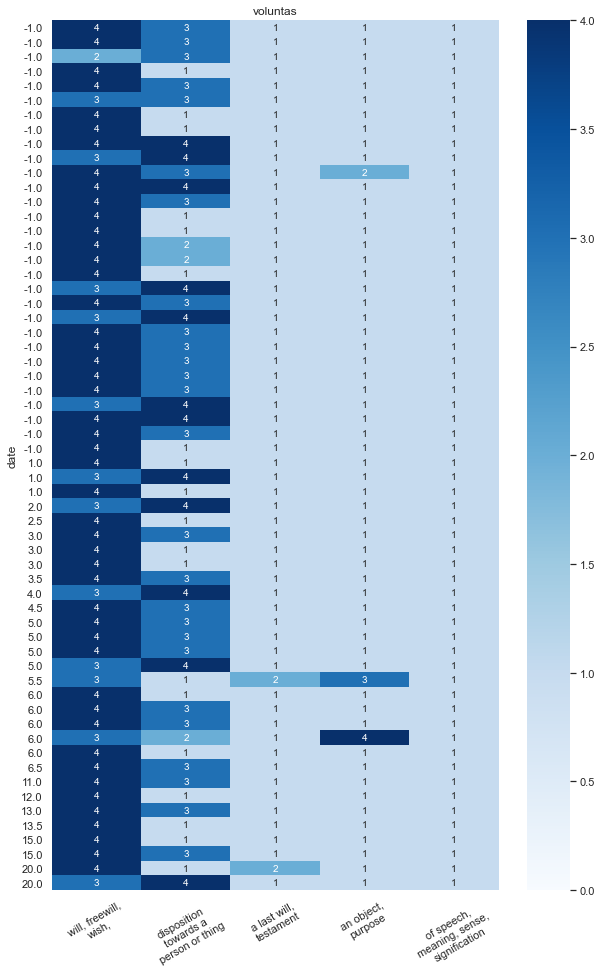

In [89]:
metadata = df['metadata']
dates = []
for line in metadata:
    print(line)
    match = re.search(',cent\. (.+?),', line)
    if match:
        datestr = match.group(1)
        century = datestr.split()[0]
        era = datestr.split()[1]
        print(datestr)
        if '-' in century:
            date = (int(century.split('-')[0])+int(century.split('-')[1]))/2
        else:
            date = int(century)
        if datestr.split()[1] == 'B.':
            date = int(-date)
        print(date)
        dates.append(date)
    else: 
        print('ERROR!')
print(dates)

df_ratings['date'] = dates
df_ratings.fillna(value=np.nan, inplace=True)

df_ratings_sorted = df_ratings.sort_values(by=['date'])
df_ratings_sorted.index = df_ratings_sorted['date']

plt.clf()
plt.figure(figsize=(10, 16))
g = seabornInstance.heatmap(df_ratings_sorted.iloc[:,:-1], 
                        cmap='Blues', 
                        vmin=0, 
                        #xticklabels=meanings_short,
                        annot=True
                       )
#g.set_xticklabels(g.get_xticklabels(), , wrap=True)
g.set_xticklabels([textwrap.fill(e.replace('\xa0', ' '), 15, break_long_words=False) for e in df_ratings_sorted.columns], rotation =30)
plt.title(s['word'])

[Text(0.5, 0, 'will, freewill,\nwish,'),
 Text(1.5, 0, 'disposition\ntowards a\nperson or thing'),
 Text(2.5, 0, 'a last will,\ntestament'),
 Text(3.5, 0, 'an object,\npurpose'),
 Text(4.5, 0, 'of speech,\nmeaning, sense,\nsignification')]

<Figure size 504x1440 with 0 Axes>

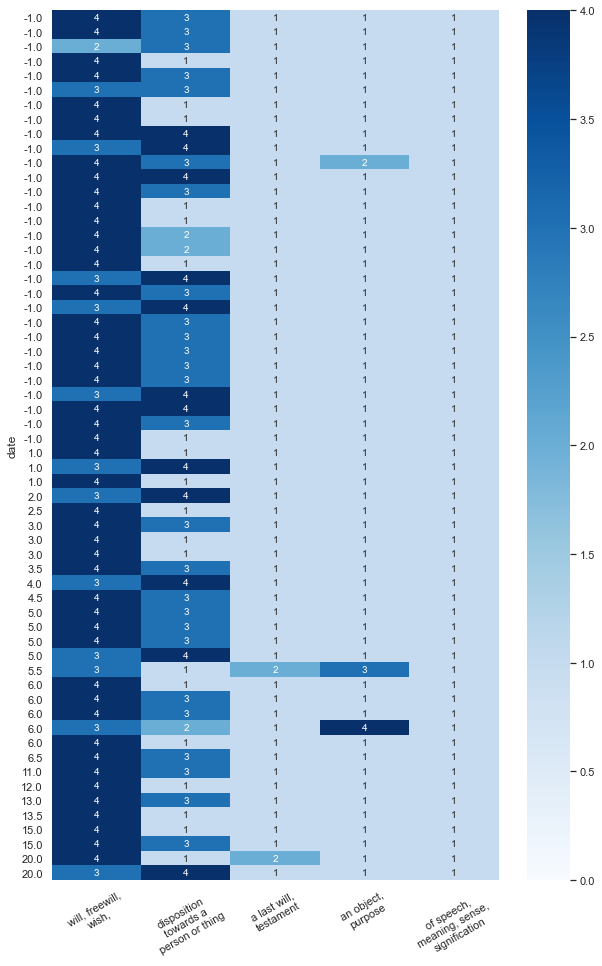

In [87]:
len(spreadsheets)

In [18]:
cumulative_df = pd.DataFrame(spreadsheets)

# Data analysis

now we want to do some analysis of "annotation styles"<br>
my df has: 'annotator', 'word', 'rows', 'meanings', 'number of meanings', 'cells', 'comments', 'number of comments', 'rating patterns', 'individual ratings frequency'<br>
for annotation "style", we need to compare annotators with each other

select annotators who did more than 1 word (we know who they are)<br>
for annotator N, we want to know:<br>
- how often they use each rating (0,1,2,3,4) => relative frequency across all spreadsheets<br>
- what patterns they use and how often<br>
- how many comments they left per annotated context

start a temporary list to store annotator statistics before making a df out of it<br>
each annotator gets a dictionary

In [19]:
ann_list = []

In [20]:
cumulative_df['annotator'].unique()

array(['ANNIE', 'DARIA', 'HUGO', 'ROZI', 'PAOLA', 'HELENA', 'TOMAZ',
       'FRANCESCA'], dtype=object)

In [21]:
for annotator in cumulative_df['annotator'].unique():
    ann = {}
    print('.'*15 + annotator + '.'*15)
    ann['annotator'] = annotator
    ann_df = cumulative_df[cumulative_df['annotator'] == annotator]
    ann['words annotated'] = len(ann_df)
    ann['cells in total'] = sum(ann_df['cells'])
    # calculate frequency of individual ratings
    irf = pd.concat(ann_df['individual ratings frequency'].to_list(), ignore_index=True).iloc[:, :2]
    printsep('//')
    #print(irf)
    irf = irf.groupby(['rating']).sum()
    irf['frequency'] = irf['absolute number'] / sum(irf['absolute number'])
    confidence = irf['frequency'][4]/(irf['frequency'][2]+irf['frequency'][3]+irf['frequency'][4])
    irf.at[len(irf)+1,'confidence'] = confidence
    ann["confidence"] = confidence
    print(irf)
    ann['individual rating frequency'] = irf
    # and also store the freqs separately in a dict:
    #ann['probabilities'] = dict(zip(irf['rating'], irf['frequency']))
    #ann['patt_probability'] = annotator_probability(ann_df['number of meanings'].max(), ann['probabilities'])
    # calculate individual patterns
    prns = pd.concat(ann_df['rating patterns'].to_list(), ignore_index=True)
    prns = prns.groupby(['pattern'], as_index=False).sum()
    prns['frequency'] = prns['count'] / sum(prns['count'])
    #prns['predicted_frequency'] = prns['pattern'].apply(lambda x: ann['patt_probability'][x])
    ann['patterns'] = prns
    print(prns)
    # calculate sets of patterns
    prns['set'] = [str(set(ast.literal_eval(x))) for x in prns['pattern']]
    sets = prns.groupby(['set'], as_index=False).sum()
    ann['sets'] = sets
    # append single annotator dictionary to a list of annotators
    ann_list.append(ann)
    printsep('//')

...............ANNIE...............
////////////////////////////////////////////////////////////
        absolute number  frequency  confidence
rating                                        
0                  13.0   0.011404         NaN
1                 622.0   0.545614         NaN
2                  66.0   0.057895         NaN
3                  23.0   0.020175         NaN
4                 416.0   0.364912         NaN
6                   NaN        NaN    0.823762
      pattern  count  frequency
0   [0, 0, 3]      1   0.002381
1   [0, 1, 3]      4   0.009524
2   [0, 1, 4]      6   0.014286
3      [0, 4]      1   0.002381
4   [1, 1, 4]    209   0.497619
5   [1, 2, 4]     63   0.150000
6   [1, 3, 4]     16   0.038095
7   [1, 4, 4]      1   0.002381
8      [1, 4]    114   0.271429
9      [2, 4]      3   0.007143
10     [3, 4]      2   0.004762
////////////////////////////////////////////////////////////
...............DARIA...............
//////////////////////////////////////////////

now write all that to an excel spreadsheet (one per annotator)

In [22]:
for a in ann_list:
    with pd.ExcelWriter(a['annotator'] +'_' + str(a['words annotated']) + '_words' '_style_export.xlsx') as writer:
        a['individual rating frequency'].to_excel(writer, sheet_name='individual rating frequency')
        a['patterns'].to_excel(writer, sheet_name='pattern frequency')
        a['sets'].to_excel(writer, sheet_name='sets used')
        #a['comments'].to_excel(writer, sheet_name='comments')

In [23]:
pp.pprint(ann_list)

[{'annotator': 'ANNIE',
  'cells in total': 1140,
  'confidence': 0.8237623762376237,
  'individual rating frequency':         absolute number  frequency  confidence
rating                                        
0                  13.0   0.011404         NaN
1                 622.0   0.545614         NaN
2                  66.0   0.057895         NaN
3                  23.0   0.020175         NaN
4                 416.0   0.364912         NaN
6                   NaN        NaN    0.823762,
  'patterns':       pattern  count  frequency        set
0   [0, 0, 3]      1   0.002381     {0, 3}
1   [0, 1, 3]      4   0.009524  {0, 1, 3}
2   [0, 1, 4]      6   0.014286  {0, 1, 4}
3      [0, 4]      1   0.002381     {0, 4}
4   [1, 1, 4]    209   0.497619     {1, 4}
5   [1, 2, 4]     63   0.150000  {1, 2, 4}
6   [1, 3, 4]     16   0.038095  {1, 3, 4}
7   [1, 4, 4]      1   0.002381     {1, 4}
8      [1, 4]    114   0.271429     {1, 4}
9      [2, 4]      3   0.007143     {2, 4}
10     [3, 4]    

  'sets':          set  count  frequency
0  {1, 2, 4}     30   0.500000
1  {1, 3, 4}     13   0.216667
2     {1, 4}      7   0.116667
3  {2, 3, 4}      4   0.066667
4     {2, 4}      5   0.083333
5     {3, 4}      1   0.016667,
  'words annotated': 1},
 {'annotator': 'TOMAZ',
  'cells in total': 360,
  'confidence': 0.7397260273972602,
  'individual rating frequency':         absolute number  frequency  confidence
rating                                        
0                   5.0   0.013889         NaN
1                 209.0   0.580556         NaN
2                   1.0   0.002778         NaN
3                  37.0   0.102778         NaN
4                 108.0   0.300000         NaN
6                   NaN        NaN    0.739726,
  'patterns':          pattern  count  frequency        set
0   [0, 0, 1, 1]      1   0.008333     {0, 1}
1         [0, 0]      1   0.008333        {0}
2   [0, 1, 1, 1]      1   0.008333     {0, 1}
3   [1, 1, 1, 2]      1   0.008333     {1, 2}
4   [1, 

In [24]:
len(ann_list)

8

now turn this list of a dictionaries into a dataframe

In [25]:
annotation_styles = pd.DataFrame(ann_list)
print(annotation_styles.columns)
print(annotation_styles)

Index(['annotator', 'words annotated', 'cells in total', 'confidence',
       'individual rating frequency', 'patterns', 'sets'],
      dtype='object')
   annotator  words annotated  cells in total  confidence  \
0      ANNIE                7            1140    0.823762   
1      DARIA               14            3472    0.521319   
2       HUGO               11            2100    0.578994   
3       ROZI                4             960    0.342105   
4      PAOLA                2             780    0.597087   
5     HELENA                1             180    0.487805   
6      TOMAZ                2             360    0.739726   
7  FRANCESCA                1             300    0.566038   

                         individual rating frequency  \
0          absolute number  frequency  confidence...   
1          absolute number  frequency  confidence...   
2          absolute number  frequency  confidence...   
3          absolute number  frequency  confidence...   
4          absolut

In [26]:
cumulative_df

,annotator,word,meanings,number of meanings,comments,number of comments,rows,cells,rating patterns,individual ratings frequency,confidence
0,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
1,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
2,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
3,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
4,DARIA,adsumo,"[take to oneself , receive ]",2,me...,2,60,120,"pattern count 0 [3, 3] 11 1 [2, 4] ...",rating absolute number frequency 0 ...,0.471264
5,ANNIE,ancilla,"[maidservant, handmaid, female slave, someone ...",2,m...,5,60,120,"pattern count 0 [1, 4] 59 1 [0, 4] ...",rating absolute number frequency 0 ...,1.000000
6,HUGO,beatus,"[blessed, rich, fortunate, happy, rewarded]",5,"Empty DataFrame Columns: [metadata, era, left ...",0,60,300,"pattern count 0 [1, 2, 3, 3, 4]...",rating absolute number frequency 0 ...,0.317204
7,HUGO,civitas,[the condition or privileges of a (roman) citi...,4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 2, 3, 4] 4 ...",rating absolute number frequency 0 ...,0.504202
8,ROZI,cohors,"[a place enclosed around, a court, enclosure, ...",4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 1, 2, 3] 1 ...",rating absolute number frequency 0 ...,0.901639
9,ANNIE,consilium,"[a conclusion made with consideration, a deter...",3,m...,10,60,180,"pattern count 0 [1, 1, 4] 45 1 [1,...",rating absolute number frequency 0 ...,0.833333


In [27]:
grouped = cumulative_df.groupby(['number of meanings'])

In [28]:
n_of_meanings = cumulative_df['number of meanings'].unique()

In [29]:
n_of_meanings

array([3, 2, 5, 4, 7, 6])

In [30]:
meanings_and_patterns = {}

In [31]:
for i in range(2,8): 
    m = grouped.get_group(i)
    meanings_and_patterns[i] = pd.concat([m['annotator'],m['word'],m['rating patterns'],m['individual ratings frequency']], axis=1)

In [32]:
 meanings_and_patterns

{2:    annotator         word                                    rating patterns  \
 4      DARIA       adsumo    pattern  count
 0  [3, 3]     11
 1  [2, 4]   ...   
 5      ANNIE      ancilla    pattern  count
 0  [1, 4]     59
 1  [0, 4]   ...   
 17     ANNIE       hostis    pattern  count
 0  [1, 4]     55
 1  [2, 4]   ...   
 20      HUGO        itero    pattern  count
 0  [1, 4]     59
 1  [4, 4]   ...   
 23      HUGO  necessarius                    pattern  count
 0  [1, 4]     60   
 26     TOMAZ      oportet    pattern  count
 0  [3, 4]     15
 1  [1, 4]   ...   
 36      HUGO      senatus    pattern  count
 0  [1, 4]     59
 1  [3, 3]   ...   
 38      ROZI      simplex    pattern  count
 0  [1, 4]     36
 1  [3, 4]   ...   
 
                          individual ratings frequency  
 4      rating  absolute number  frequency
 0       ...  
 5      rating  absolute number  frequency
 0       ...  
 17     rating  absolute number  frequency
 0       ...  
 20     rating  abso

In [33]:
confidence_meanings = {}

In [34]:
for key in meanings_and_patterns:
    # the value is a df
    nr_df = meanings_and_patterns[key]
    w_and_a = nr_df.iloc[:, 0:2]
    prns = pd.concat(nr_df['rating patterns'].to_list(), ignore_index=True)
    prns = prns.groupby(['pattern'], as_index=False).sum()
    prns['frequency'] = prns['count'] / sum(prns['count'])
    irfs = pd.concat(nr_df['individual ratings frequency'].to_list(), ignore_index=True)
    irfs = irfs.groupby(['rating'], as_index=False).sum()
    irfs['frequency'] = irfs['absolute number']/sum(irfs['absolute number'])
    confidence = irfs['frequency'][4]/(irfs['frequency'][2]+irfs['frequency'][3]+irfs['frequency'][4])
    irfs.at[len(irfs),'confidence'] = confidence
    confidence_meanings[key] = confidence
    with pd.ExcelWriter('{} meanings.xlsx'.format(key)) as writer:
        w_and_a.to_excel(writer, sheet_name='annotators and words')
        irfs.to_excel(writer, sheet_name='rating frequency')
        prns.to_excel(writer, sheet_name='pattern frequency')

In [35]:
confidence_meanings

{2: 0.8185117967332123,
 3: 0.6459948320413437,
 4: 0.5147569444444444,
 5: 0.4314516129032258,
 6: 0.33409610983981697,
 7: 0.5025380710659898}

In [36]:
annotators_confidence = {dict["annotator"]:dict["confidence"] for dict in ann_list}

In [37]:
annotators_confidence

{'ANNIE': 0.8237623762376237,
 'DARIA': 0.5213193885760257,
 'HUGO': 0.5789938217122683,
 'ROZI': 0.3421052631578947,
 'PAOLA': 0.5970873786407767,
 'HELENA': 0.4878048780487805,
 'TOMAZ': 0.7397260273972602,
 'FRANCESCA': 0.5660377358490566}

## now we have two values: 
- expected confidence of a specific annotator
- expected confidence for a word with N meanings

e.g. the overall confidence of a word with 6 meanings is 0.34

normal vs. "virtus" confidence is as follows:

annotator: normal confidence: virtus confidence

    ANNIE: 0.82 – 0.35
    DARIA: 0.52 – 0.47
    HUGO:  0.57 – 0.32
    ROZI:  0.34 – 0.26

In [38]:
cumulative_df

,annotator,word,meanings,number of meanings,comments,number of comments,rows,cells,rating patterns,individual ratings frequency,confidence
0,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
1,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
2,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
3,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,0.766234
4,DARIA,adsumo,"[take to oneself , receive ]",2,me...,2,60,120,"pattern count 0 [3, 3] 11 1 [2, 4] ...",rating absolute number frequency 0 ...,0.471264
5,ANNIE,ancilla,"[maidservant, handmaid, female slave, someone ...",2,m...,5,60,120,"pattern count 0 [1, 4] 59 1 [0, 4] ...",rating absolute number frequency 0 ...,1.000000
6,HUGO,beatus,"[blessed, rich, fortunate, happy, rewarded]",5,"Empty DataFrame Columns: [metadata, era, left ...",0,60,300,"pattern count 0 [1, 2, 3, 3, 4]...",rating absolute number frequency 0 ...,0.317204
7,HUGO,civitas,[the condition or privileges of a (roman) citi...,4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 2, 3, 4] 4 ...",rating absolute number frequency 0 ...,0.504202
8,ROZI,cohors,"[a place enclosed around, a court, enclosure, ...",4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 1, 2, 3] 1 ...",rating absolute number frequency 0 ...,0.901639
9,ANNIE,consilium,"[a conclusion made with consideration, a deter...",3,m...,10,60,180,"pattern count 0 [1, 1, 4] 45 1 [1,...",rating absolute number frequency 0 ...,0.833333


In [39]:
# counting the number of different patterns / number of possible combinations 
from scipy.special import comb
cumulative_df['count of patterns'] = cumulative_df['rating patterns'].apply(lambda x: x.shape[0])
cumulative_df['count of all possible patterns'] = comb(5, cumulative_df['number of meanings'], repetition=True)
cumulative_df['% of possible pp used'] = cumulative_df['count of patterns'] / cumulative_df['count of all possible patterns']

In [40]:
for i in range(cumulative_df.shape[0]):
    print(cumulative_df['word'][i])
    print('this word has ' + str(cumulative_df['number of meanings'][i]) + ' meanings')
    pp.pprint(cumulative_df['meanings'][i])
    printsep('.')

acerbus
this word has 3 meanings
['harsh to the taste, harsh, unripe',
 '(of people) rough, violent',
 '(of things) heavy, sad, bitter']
..............................
acerbus
this word has 3 meanings
['harsh to the taste, harsh, unripe',
 '(of people) rough, violent',
 '(of things) heavy, sad, bitter']
..............................
acerbus
this word has 3 meanings
['harsh to the taste, harsh, unripe',
 '(of people) rough, violent',
 '(of things) heavy, sad, bitter']
..............................
acerbus
this word has 3 meanings
['harsh to the taste, harsh, unripe',
 '(of people) rough, violent',
 '(of things) heavy, sad, bitter']
..............................
adsumo
this word has 2 meanings
['take to oneself ', 'receive ']
..............................
ancilla
this word has 2 meanings
['maidservant, handmaid, female slave', 'someone servilely devoted to anything']
..............................
beatus
this word has 5 meanings
['blessed', 'rich', 'fortunate', 'happy', 'rewarded']
.

# Dataframe of confidences

In [41]:
confidence_df = cumulative_df.loc[:, ['annotator', 'word', 'number of meanings', 'confidence', 'count of patterns','count of all possible patterns', '% of possible pp used']]

In [42]:
%matplotlib inline

In [43]:
annotation_styles

,annotator,words annotated,cells in total,confidence,individual rating frequency,patterns,sets
0,ANNIE,7,1140,0.823762,absolute number frequency confidence...,pattern count frequency set 0 ...,"set count frequency 0 {0, 1, 3} ..."
1,DARIA,14,3472,0.521319,absolute number frequency confidence...,pattern count frequency ...,"set count frequency 0 {0, 1, ..."
2,HUGO,11,2100,0.578994,absolute number frequency confidence...,pattern count frequency ...,"set count frequency 0 {0, 1, ..."
3,ROZI,4,960,0.342105,absolute number frequency confidence...,pattern count frequency ...,"set count frequency 0 {0, ..."
4,PAOLA,2,780,0.597087,absolute number frequency confidence...,pattern count frequency ...,"set count frequency 0 {1, 2, 3,..."
5,HELENA,1,180,0.487805,absolute number frequency confidence...,pattern count frequency set 0 [...,"set count frequency 0 {1, 2, 4} ..."
6,TOMAZ,2,360,0.739726,absolute number frequency confidence...,pattern count frequency set ...,"set count frequency 0 {0, 1} ..."
7,FRANCESCA,1,300,0.566038,absolute number frequency confidence...,pattern count frequency ...,"set count frequency 0 {1, 2, 3,..."


In [44]:
confidence_df['expected confidence: annotator'] = confidence_df['annotator'].apply(lambda x: annotators_confidence[x])

In [45]:
confidence_df['expected confidence: nr of meanings'] = confidence_df['number of meanings'].apply(lambda x: confidence_meanings[x])

In [46]:
confidence_df['diff to annotator'] = confidence_df['expected confidence: annotator']-confidence_df['confidence']
confidence_df['diff to meanings'] = confidence_df['expected confidence: nr of meanings']-confidence_df['confidence']

In [47]:
words_data = read_excel('Words_qualities.xlsx', sheet_name=0, encoding='utf-8', dtype=object)

In [48]:
words_data

,word,target or control?,POS,number of meanings,L&S hierarchy,meaning clusters,comments
0,acerbus,control,adj,3,"Ι.A, ΙΙ.Α, ΙΙ.Β",3,1 base + 2 fig
1,adsumo,control,verb,2,"I, II",2,2 similar
2,ancilla,control,subst,2,"I, II",2,1 base + 1 fig
3,beatus,target,adj,5,"A.1, B.1, A.1/A.3, A.1/A.3, A.1",4,NaN
4,civitas,target,subst,4,"I.A, II.A, II.B.1, II.B.2",4,4 specific
5,cohors,target,subst,4,"I, II.A.1, II.C, II.B",3,1 + 2 + 1
6,consilium,control,subst,3,"II.A.I, II.A.2, II.B",3,NaN
7,consul,target,subst,4,"I, II.A, II.C, II.B",3,2 + 1 + 1
8,credo,target,verb,7,"I, II.A, II.B, II.C.1, II.C.2.a, II.C.2.b, II.B.2",5,1 + 1 + 2 + 2 + 1
9,dolus,target,subst,4,"I, II, III.B, none",4,2 + 1 + 1


In [49]:
new_conf_df = pd.merge(left=confidence_df, right=words_data, how='right', left_on=['word', 'number of meanings'], right_on=['word', 'number of meanings'])

In [50]:
new_conf_df

,annotator,word,number of meanings,confidence,count of patterns,count of all possible patterns,% of possible pp used,expected confidence: annotator,expected confidence: nr of meanings,diff to annotator,diff to meanings,target or control?,POS,L&S hierarchy,meaning clusters,comments
0,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239,control,adj,"Ι.A, ΙΙ.Α, ΙΙ.Β",3,1 base + 2 fig
1,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239,control,adj,"Ι.A, ΙΙ.Α, ΙΙ.Β",3,1 base + 2 fig
2,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239,control,adj,"Ι.A, ΙΙ.Α, ΙΙ.Β",3,1 base + 2 fig
3,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239,control,adj,"Ι.A, ΙΙ.Α, ΙΙ.Β",3,1 base + 2 fig
4,DARIA,adsumo,2,0.471264,7,15.0,0.466667,0.521319,0.818512,0.050055,0.347247,control,verb,"I, II",2,2 similar
5,ANNIE,ancilla,2,1.000000,2,15.0,0.133333,0.823762,0.818512,-0.176238,-0.181488,control,subst,"I, II",2,1 base + 1 fig
6,HUGO,beatus,5,0.317204,15,126.0,0.119048,0.578994,0.431452,0.261790,0.114247,target,adj,"A.1, B.1, A.1/A.3, A.1/A.3, A.1",4,NaN
7,HUGO,civitas,4,0.504202,8,70.0,0.114286,0.578994,0.514757,0.074792,0.010555,target,subst,"I.A, II.A, II.B.1, II.B.2",4,4 specific
8,ROZI,cohors,4,0.901639,6,70.0,0.085714,0.342105,0.514757,-0.559534,-0.386882,target,subst,"I, II.A.1, II.C, II.B",3,1 + 2 + 1
9,ANNIE,consilium,3,0.833333,5,35.0,0.142857,0.823762,0.645995,-0.009571,-0.187339,control,subst,"II.A.I, II.A.2, II.B",3,NaN


In [51]:
confidence_df.to_excel('Confidence comparison.xlsx')

In [52]:
confidence_df

,annotator,word,number of meanings,confidence,count of patterns,count of all possible patterns,% of possible pp used,expected confidence: annotator,expected confidence: nr of meanings,diff to annotator,diff to meanings
0,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239
1,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239
2,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239
3,ANNIE,acerbus,3,0.766234,5,35.0,0.142857,0.823762,0.645995,0.057529,-0.120239
4,DARIA,adsumo,2,0.471264,7,15.0,0.466667,0.521319,0.818512,0.050055,0.347247
5,ANNIE,ancilla,2,1.000000,2,15.0,0.133333,0.823762,0.818512,-0.176238,-0.181488
6,HUGO,beatus,5,0.317204,15,126.0,0.119048,0.578994,0.431452,0.261790,0.114247
7,HUGO,civitas,4,0.504202,8,70.0,0.114286,0.578994,0.514757,0.074792,0.010555
8,ROZI,cohors,4,0.901639,6,70.0,0.085714,0.342105,0.514757,-0.559534,-0.386882
9,ANNIE,consilium,3,0.833333,5,35.0,0.142857,0.823762,0.645995,-0.009571,-0.187339


In [53]:
confidence_df.describe()

,number of meanings,confidence,count of patterns,count of all possible patterns,% of possible pp used,expected confidence: annotator,expected confidence: nr of meanings,diff to annotator,diff to meanings
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,3.690476,0.629613,6.761905,76.404762,0.136487,0.584039,0.591816,-0.045574,-0.037796
std,1.352290,0.220047,3.469797,77.293568,0.090229,0.135264,0.143017,0.193265,0.174007
min,2.000000,0.130435,1.000000,15.000000,0.024242,0.342105,0.334096,-0.559534,-0.421751
25%,3.000000,0.491904,5.000000,35.000000,0.085714,0.521319,0.514757,-0.120530,-0.160787
50%,3.500000,0.597789,6.500000,52.500000,0.123810,0.578994,0.580376,0.002022,-0.072176
75%,4.000000,0.766234,8.000000,70.000000,0.142857,0.592564,0.645995,0.070422,0.094949
max,7.000000,1.000000,17.000000,330.000000,0.466667,0.823762,0.818512,0.261790,0.347247


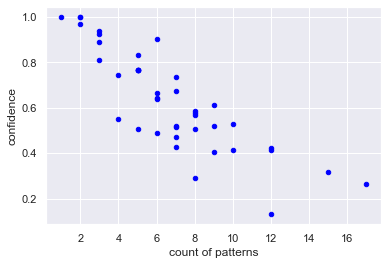

In [54]:
new_conf_df.plot.scatter(y='confidence', x='count of patterns', color='blue')

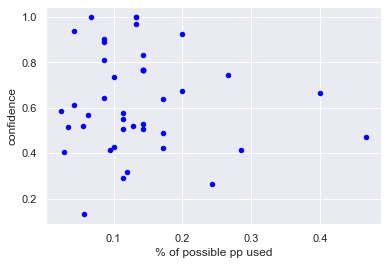

In [55]:
new_conf_df.plot.scatter(y='confidence', x='% of possible pp used', color='blue')

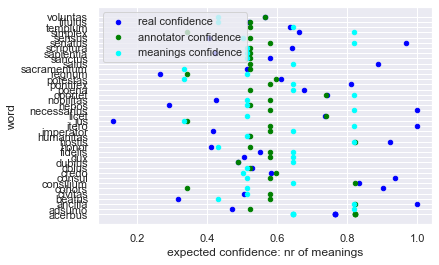

In [56]:
ax = confidence_df.plot.scatter(x='confidence', y='word', color='blue', label='real confidence')
confidence_df.plot.scatter(x='expected confidence: annotator', y='word', color='green', ax=ax, label='annotator confidence')
confidence_df.plot.scatter(x='expected confidence: nr of meanings', y='word', color='cyan', ax=ax, label='meanings confidence', )

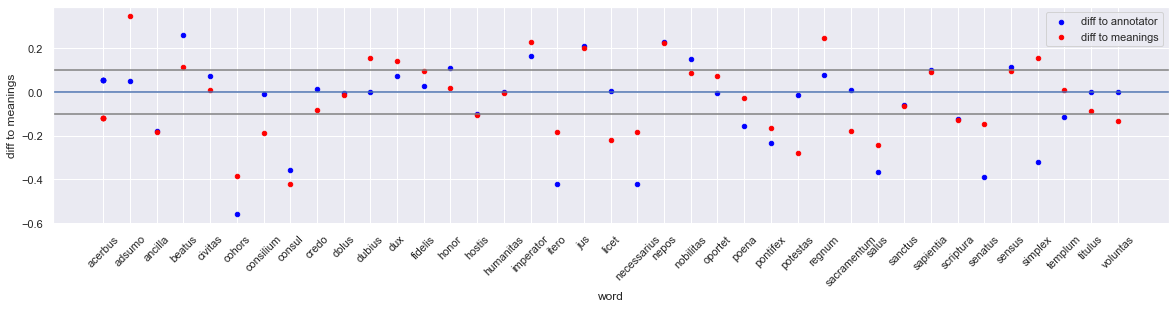

In [57]:
plt.rcParams['figure.figsize'] = [20, 4]
pl = confidence_df.plot.scatter(x='word', y='diff to annotator', color='blue', label='diff to annotator')
confidence_df.plot.scatter(x='word', y='diff to meanings', color='red', label='diff to meanings', ax=pl)
plt.xticks(rotation=45)
plt.axhline(y=0.1, c='gray')
plt.axhline(y=-0.1, c='gray')
plt.axhline()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


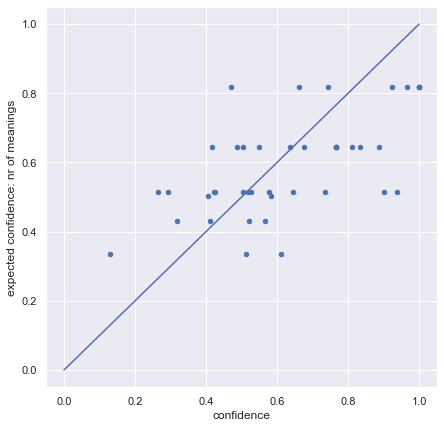

In [58]:
pl = confidence_df.plot.scatter(x='confidence', y='expected confidence: nr of meanings', figsize=[7,7])
pl.plot([0, 1], [0, 1])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


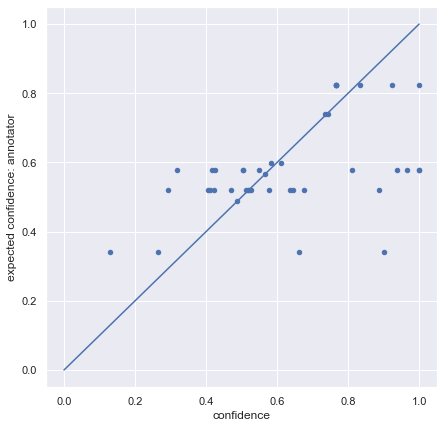

In [59]:
pl = confidence_df.plot.scatter(x='confidence', y='expected confidence: annotator', figsize=[7,7])
pl.plot([0, 1], [0, 1])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


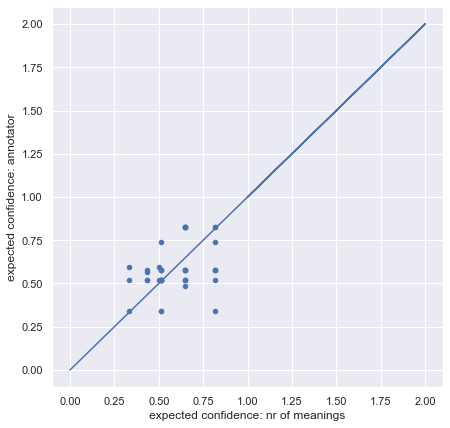

In [60]:
pl = confidence_df.plot.scatter(x='expected confidence: nr of meanings', y='expected confidence: annotator', figsize=[7,7])
pl.plot([0,2, 1,2], [0,2, 1,2])

# Linear regression models

## Model #1: based on expected confidences

In [61]:
X = confidence_df[['expected confidence: annotator', 'expected confidence: nr of meanings']].values

In [62]:
y = confidence_df['confidence'].values

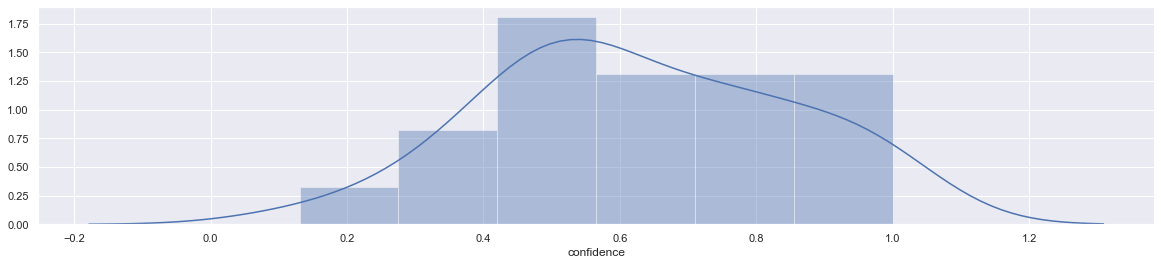

In [63]:
seabornInstance.distplot(confidence_df['confidence'])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [66]:
y_pred = regressor.predict(X_test)

In [67]:
y_pred

array([0.473086  , 0.82164002, 0.65355185, 0.79922602, 0.56514794,
       0.56514794, 0.67596585, 0.56186195, 0.53241626])

In [68]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [69]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

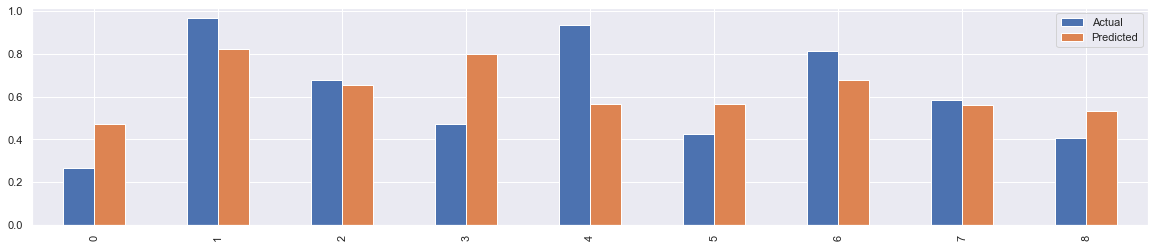

In [70]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [71]:
confidence_df['confidence'].mean()

0.6296125571722608

In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.16642055834499173
Mean Squared Error: 0.04051017115438123
Root Mean Squared Error: 0.20127138682480733


### Test 2: R squared 

In [73]:
metrics.r2_score(y_test, y_pred)

0.26075948447293784

In [74]:
metrics.explained_variance_score(y_test, y_pred) # maximum value is 1 and is desirable

0.2633746228437098

In [75]:
metrics.max_error(y_test, y_pred) 

0.3713600003081946

In [76]:
metrics.median_absolute_error(y_test, y_pred)

0.13961602130612488

## Model #2: based on (1) annotator confidence; (2) number of meanings 

In [77]:
X = confidence_df[['expected confidence: annotator', 'number of meanings']].values
#X = confidence_df['expected confidence: annotator'].values.reshape(-1,1)

In [78]:
y = confidence_df['confidence'].values

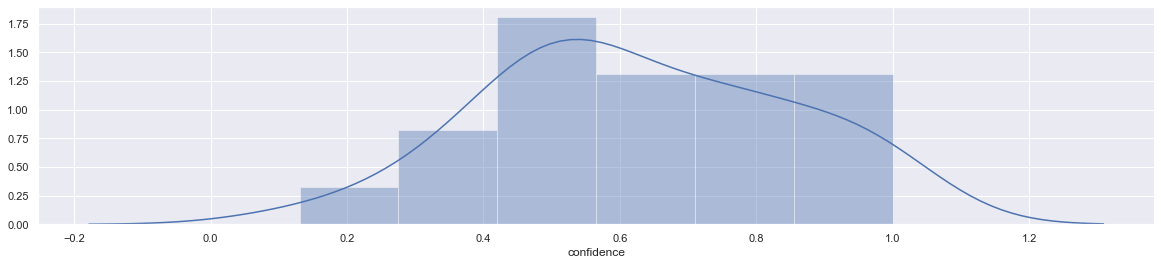

In [79]:
seabornInstance.distplot(confidence_df['confidence'])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [82]:
y_pred = regressor.predict(X_test)

In [83]:
y_pred

array([0.49305272, 0.78612206, 0.6636766 , 0.76325989, 0.58695548,
       0.58695548, 0.68653877, 0.29537791, 0.26534344])

In [84]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [85]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

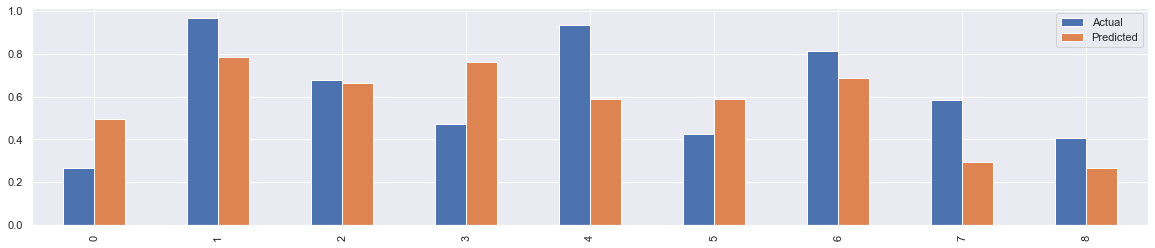

In [86]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [87]:
confidence_df['confidence'].mean()

0.6296125571722608

In [88]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.19714655745699783
Mean Squared Error: 0.048421534620680336
Root Mean Squared Error: 0.22004893687696003


### Test 2: R squared is in the interval (0, 1), the greater the better

In [89]:
metrics.r2_score(y_test, y_pred)

0.11639079284087583

# Model #3: Based on annotator and number of meanings

In [90]:
annotators = pd.get_dummies(cumulative_df['annotator'])

In [91]:
annotators

,ANNIE,DARIA,FRANCESCA,HELENA,HUGO,PAOLA,ROZI,TOMAZ
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0
7,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,1,0
9,1,0,0,0,0,0,0,0


In [92]:
train = pd.concat([cumulative_df, annotators], axis=1)

In [93]:
train

,annotator,word,meanings,number of meanings,comments,number of comments,rows,cells,rating patterns,individual ratings frequency,...,count of all possible patterns,% of possible pp used,ANNIE,DARIA,FRANCESCA,HELENA,HUGO,PAOLA,ROZI,TOMAZ
0,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,...,35.0,0.142857,1,0,0,0,0,0,0,0
1,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,...,35.0,0.142857,1,0,0,0,0,0,0,0
2,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,...,35.0,0.142857,1,0,0,0,0,0,0,0
3,ANNIE,acerbus,"[harsh to the taste, harsh, unripe, (of people...",3,m...,2,60,180,"pattern count 0 [1, 1, 4] 41 1 [1,...",rating absolute number frequency 0 ...,...,35.0,0.142857,1,0,0,0,0,0,0,0
4,DARIA,adsumo,"[take to oneself , receive ]",2,me...,2,60,120,"pattern count 0 [3, 3] 11 1 [2, 4] ...",rating absolute number frequency 0 ...,...,15.0,0.466667,0,1,0,0,0,0,0,0
5,ANNIE,ancilla,"[maidservant, handmaid, female slave, someone ...",2,m...,5,60,120,"pattern count 0 [1, 4] 59 1 [0, 4] ...",rating absolute number frequency 0 ...,...,15.0,0.133333,1,0,0,0,0,0,0,0
6,HUGO,beatus,"[blessed, rich, fortunate, happy, rewarded]",5,"Empty DataFrame Columns: [metadata, era, left ...",0,60,300,"pattern count 0 [1, 2, 3, 3, 4]...",rating absolute number frequency 0 ...,...,126.0,0.119048,0,0,0,0,1,0,0,0
7,HUGO,civitas,[the condition or privileges of a (roman) citi...,4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 2, 3, 4] 4 ...",rating absolute number frequency 0 ...,...,70.0,0.114286,0,0,0,0,1,0,0,0
8,ROZI,cohors,"[a place enclosed around, a court, enclosure, ...",4,"Empty DataFrame Columns: [metadata, era, left ...",0,60,240,"pattern count 0 [1, 1, 2, 3] 1 ...",rating absolute number frequency 0 ...,...,70.0,0.085714,0,0,0,0,0,0,1,0
9,ANNIE,consilium,"[a conclusion made with consideration, a deter...",3,m...,10,60,180,"pattern count 0 [1, 1, 4] 45 1 [1,...",rating absolute number frequency 0 ...,...,35.0,0.142857,1,0,0,0,0,0,0,0


In [94]:
X = train[['ANNIE', 'DARIA', 'FRANCESCA', 'HELENA', 'HUGO', 'PAOLA', 'ROZI', 'TOMAZ']].values

In [95]:
y = confidence_df['confidence'].values

In [96]:
y

array([0.76623377, 0.76623377, 0.76623377, 0.76623377, 0.47126437,
       1.        , 0.3172043 , 0.50420168, 0.90163934, 0.83333333,
       0.93650794, 0.58333333, 0.52747253, 0.48780488, 0.5042735 ,
       0.55045872, 0.41176471, 0.92307692, 0.51898734, 0.41549296,
       1.        , 0.13043478, 0.73611111, 1.        , 0.29166667,
       0.42553191, 0.74324324, 0.67532468, 0.81081081, 0.6122449 ,
       0.26582278, 0.51376147, 0.88709677, 0.57831325, 0.42156863,
       0.64367816, 0.96721311, 0.40449438, 0.6626506 , 0.63636364,
       0.51960784, 0.56603774])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [98]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [99]:
y_pred = regressor.predict(X_test)

In [100]:
y_pred

array([0.56490824, 0.61309017, 0.54093464, 0.54093464, 0.61309017,
       0.61309017, 0.61309017, 0.6122449 , 0.54093464])

In [101]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [102]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

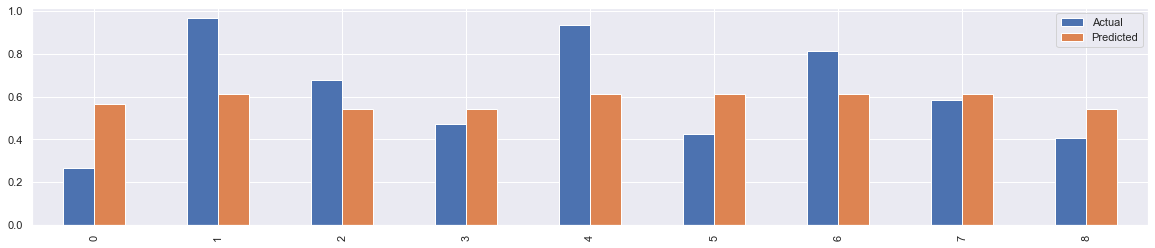

In [103]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [104]:
confidence_df['confidence'].mean()

0.6296125571722608

In [105]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.19236857790269027
Mean Squared Error: 0.04845469227322122
Root Mean Squared Error: 0.2201242655256826


### Test 2: R squared is in the interval (0, 1), the greater the better

In [106]:
metrics.r2_score(y_test, y_pred)

0.11578572306556989

> Interim results: models do not look too good. The best results were achieved by the model based on "annotator confidence" and "meanings confidence". 

# Model #4: based on (1) count of patterns and (2) number of meanings
**< Spoiler: the best R-squared so far >**

In [107]:
X = new_conf_df[['count of patterns', 'number of meanings']].values

In [108]:
y = confidence_df['confidence'].values

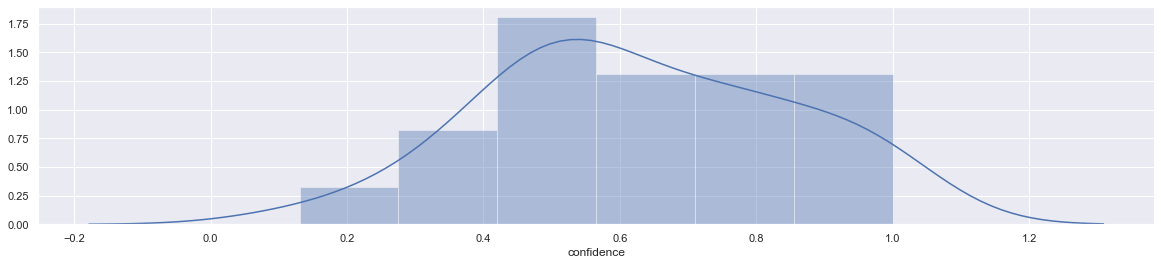

In [109]:
seabornInstance.distplot(confidence_df['confidence'])

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [112]:
y_pred = regressor.predict(X_test)

In [113]:
y_pred

array([0.10504623, 0.90312143, 0.63036641, 0.65055629, 0.81222864,
       0.61017653, 0.83241852, 0.49909385, 0.44858082])

In [114]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [115]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

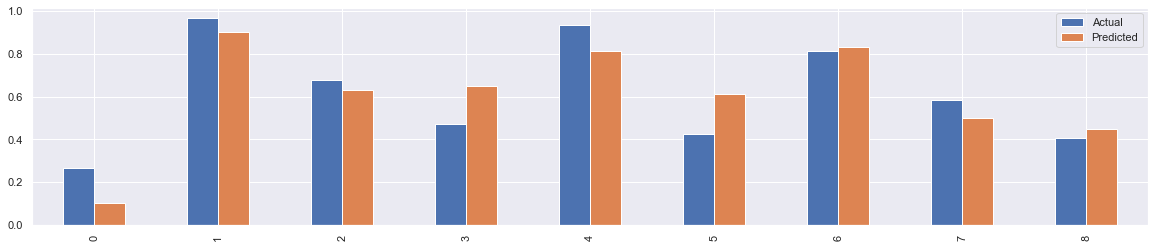

In [116]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [117]:
new_conf_df['confidence'].mean()

0.6296125571722608

In [118]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1008862178270185
Mean Squared Error: 0.013685494938955904
Root Mean Squared Error: 0.116985020147692


### Test 2: R squared 

In [119]:
metrics.r2_score(y_test, y_pred)

0.7502634018661111

In [120]:
metrics.explained_variance_score(y_test, y_pred) # maximum value is 1 and is desirable

0.7507980337247955

In [121]:
metrics.max_error(y_test, y_pred) 

0.184644610274375

In [122]:
metrics.median_absolute_error(y_test, y_pred)

0.08423948173859219

# Model #5: based on (1) meaning clusters and (2) count of patterns

In [123]:
X = new_conf_df[['count of patterns', 'meaning clusters']].values

In [124]:
y = confidence_df['confidence'].values

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [126]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [127]:
y_pred = regressor.predict(X_test)

In [128]:
y_pred

array([0.01529337, 0.89096007, 0.61233135, 0.59244108, 0.85114655,
       0.61233135, 0.83125627, 0.59240811, 0.51281403])

In [129]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [130]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

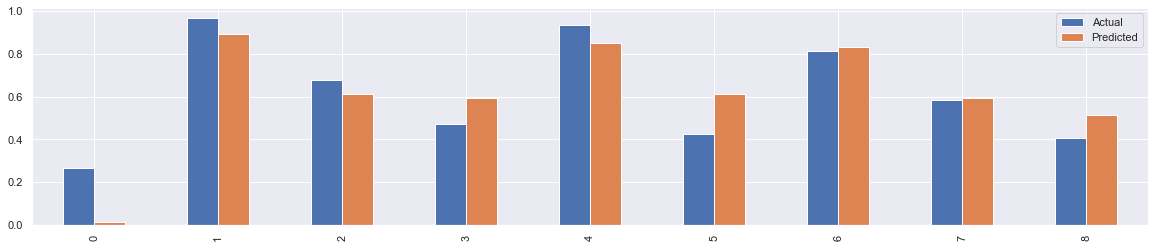

In [131]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [132]:
new_conf_df['confidence'].mean()

0.6296125571722608

In [133]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.10232813408801417
Mean Squared Error: 0.01573839800704899
Root Mean Squared Error: 0.12545277201819413


### Test 2: R squared 

In [134]:
metrics.r2_score(y_test, y_pred)

0.7128014736851414

In [135]:
metrics.explained_variance_score(y_test, y_pred) # maximum value is 1 and is desirable

0.7129951595583177

In [136]:
metrics.max_error(y_test, y_pred) 

0.2505294187839745

In [137]:
metrics.median_absolute_error(y_test, y_pred)

0.08536138599535947

> Model #5 performs worse than model #4


# Model # whatever

# Model #whatever:  a model to play around with

In [138]:
t = pd.get_dummies(new_conf_df['target or control?'])

In [139]:
pd_out = pd.concat([new_conf_df,t], axis=1)
new_conf_df = pd_out

In [140]:
new_conf_df.describe()

,confidence,count of patterns,count of all possible patterns,% of possible pp used,expected confidence: annotator,expected confidence: nr of meanings,diff to annotator,diff to meanings,control,target
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.629613,6.761905,76.404762,0.136487,0.584039,0.591816,-0.045574,-0.037796,0.571429,0.428571
std,0.220047,3.469797,77.293568,0.090229,0.135264,0.143017,0.193265,0.174007,0.500870,0.500870
min,0.130435,1.000000,15.000000,0.024242,0.342105,0.334096,-0.559534,-0.421751,0.000000,0.000000
25%,0.491904,5.000000,35.000000,0.085714,0.521319,0.514757,-0.120530,-0.160787,0.000000,0.000000
50%,0.597789,6.500000,52.500000,0.123810,0.578994,0.580376,0.002022,-0.072176,1.000000,0.000000
75%,0.766234,8.000000,70.000000,0.142857,0.592564,0.645995,0.070422,0.094949,1.000000,1.000000
max,1.000000,17.000000,330.000000,0.466667,0.823762,0.818512,0.261790,0.347247,1.000000,1.000000


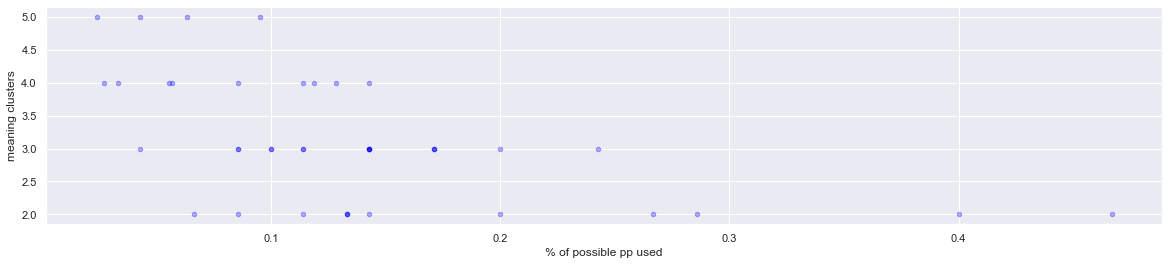

In [141]:
new_conf_df.plot.scatter(y='meaning clusters', x='% of possible pp used', color='blue', alpha=0.3)

In [154]:
X = new_conf_df[['target', 'control', 'number of meanings', 'count of patterns']].values

In [155]:
y = confidence_df['confidence'].values

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [157]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [158]:
y_pred = regressor.predict(X_test)

In [159]:
y_pred

array([0.09891284, 0.90080863, 0.63830106, 0.64806614, 0.81866089,
       0.60439781, 0.84049505, 0.50041591, 0.43779834])

In [160]:
y_test

array([0.26582278, 0.96721311, 0.67532468, 0.47126437, 0.93650794,
       0.42553191, 0.81081081, 0.58333333, 0.40449438])

In [161]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=range(len(y_test)))

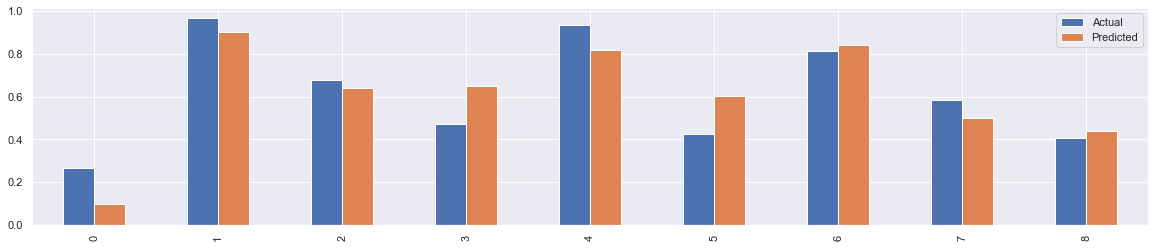

In [162]:
df.plot(kind='bar')

### Test 1: Mean absolute error should be within the 10% range of the mean confidence value.

In [163]:
new_conf_df['confidence'].mean()

0.6296125571722608

In [164]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.09886204279428994
Mean Squared Error: 0.013293849322787599
Root Mean Squared Error: 0.1152989562953091


### Test 2: R squared 

In [165]:
metrics.r2_score(y_test, y_pred)

0.7574102565682754

In [166]:
metrics.explained_variance_score(y_test, y_pred) # maximum value is 1 and is desirable

0.7580299436593844

In [167]:
metrics.max_error(y_test, y_pred) 

0.1788658998012282

In [168]:
metrics.median_absolute_error(y_test, y_pred)

0.08291741933322416